In [1]:
# Want to track the dow jones and use indicators
# from: https://medium.com/fintechexplained/automating-stock-investing-technical-analysis-with-python-81c669e360b2
# MACD
# Calculate the MACD line: 
"""
Calculate the 26-day exponentially weighted moving average of the price. This is the long term line.
Calculate the 12-day exponentially weighted moving average of the price. This is the short term line.
Calculate the difference between the 26-day EMA and 12-day EMA lines. This is the MACD line.
"""
# Calculate the Signal line from the MACD line:
"""
Calculate the 9 days exponentially weighted moving average of the MACD line. This is known as the signal line.
We can then calculate the difference between the MACD and the Signal line and then plot it as a histogram. 
The histogram can help us find when the cross-over is about to happen.
"""
# RSI
"""
The calculation is extremely simple.
Firstly, we have to determine the time period. Usually, a 14 day time period is chosen but it could depend on the investor’s own view of the market and the stock.
Secondly, we have to compute the relative strength which is known as RS. RS is the average gain over the average loss. To explain it further, RS is the average gain when the price was moving up over the average loss when the price change was negative.
Calculate RSI as 100 — (100/(1+RS))
The RSI value is between 0–100
"""
# Bollinger Bands
"""
Middle band: Calculate the moving average of the price, usually 20 days moving average.
Upper band: Calculate two standard deviations above the moving average.
Lower band: Calculate two standard deviations below the moving average.
"""

'\nMiddle band: Calculate the moving average of the price, usually 20 days moving average.\nUpper band: Calculate two standard deviations above the moving average.\nLower band: Calculate two standard deviations below the moving average.\n'

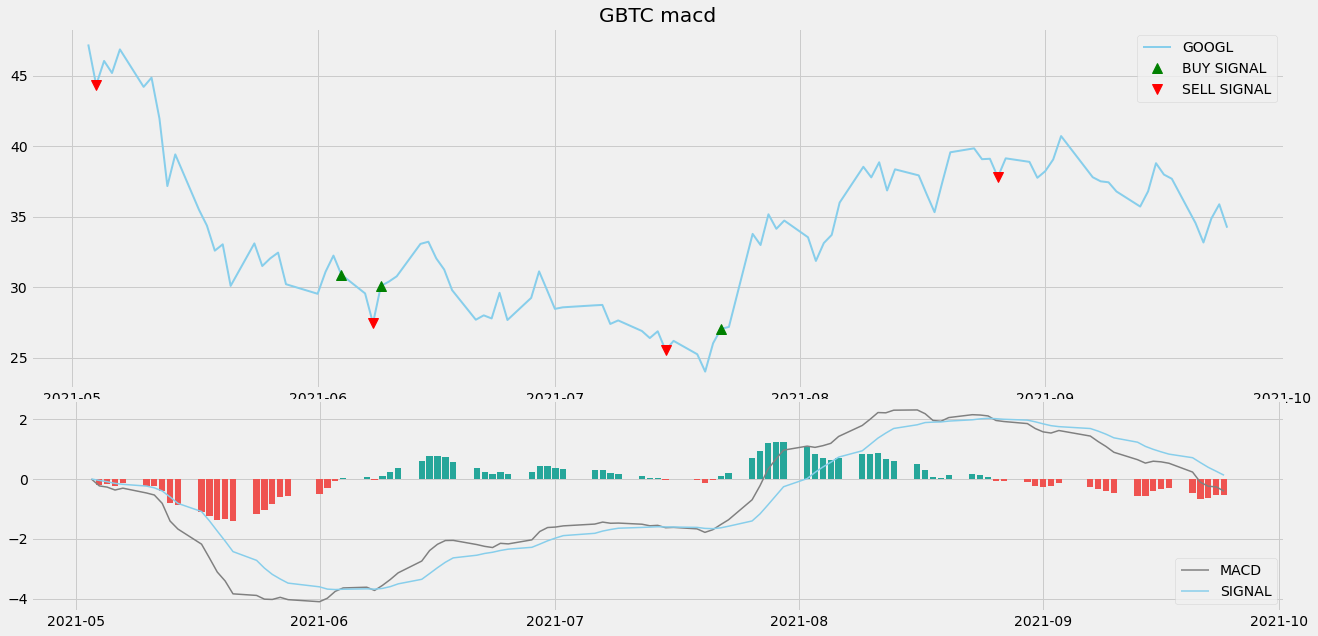

In [9]:
# MACD
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

def get_historical_data(symbol, start_date = None):
    api_key = '00f83bac51mshba5c44255841b11p11d607jsnf6d25aeeaebe'
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&market=CNY&apikey={api_key}&outputsize=full'
    # 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market=CNY&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

googl = get_historical_data('GBTC', '2021-05-01')
googl


def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

googl_macd = get_macd(googl['close'], 26, 12, 9)
googl_macd.tail()

def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(googl['close'], googl_macd['macd'], googl_macd['signal'], googl_macd['hist'])

def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(googl['close'], googl_macd)

ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(googl['close'], color = 'skyblue', linewidth = 2, label = 'GOOGL')
ax1.plot(googl.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(googl.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('GBTC macd')
ax2.plot(googl_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(googl_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(googl_macd)):
    if str(googl_macd['hist'][i])[0] == '-':
        ax2.bar(googl_macd.index[i], googl_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(googl_macd.index[i], googl_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

             open     high      low    close  adj close    volume
2021-04-14  37.65  37.8400  33.1450  33.2100    33.2100  102967.0
2021-04-15  33.86  34.1999  31.6500  32.6900    32.6900  330908.0
2021-04-16  31.86  32.0299  30.8501  31.7700    31.7700  125592.0
2021-04-19  30.25  30.5669  28.5200  29.5300    29.5300  216843.0
2021-04-20  29.30  29.3000  27.6770  28.8400    28.8400   85036.0
...           ...      ...      ...      ...        ...       ...
2021-09-20  25.38  25.3800  24.0100  24.3800    24.3800   52077.0
2021-09-21  24.38  24.7250  24.0100  24.2100    24.2100   36985.0
2021-09-22  24.34  25.3300  24.2910  25.1300    25.1300   25889.0
2021-09-23  25.54  25.6200  25.2400  25.5787    25.5787   21575.0
2021-09-24  24.43  24.5550  24.0500  24.4200    24.4200   52481.0

[115 rows x 6 columns]
             open     high      low    close  adj close    volume     rsi_14
2021-04-20  29.30  29.3000  27.6770  28.8400    28.8400   85036.0   0.000000
2021-04-21  28.40  30.2800  27

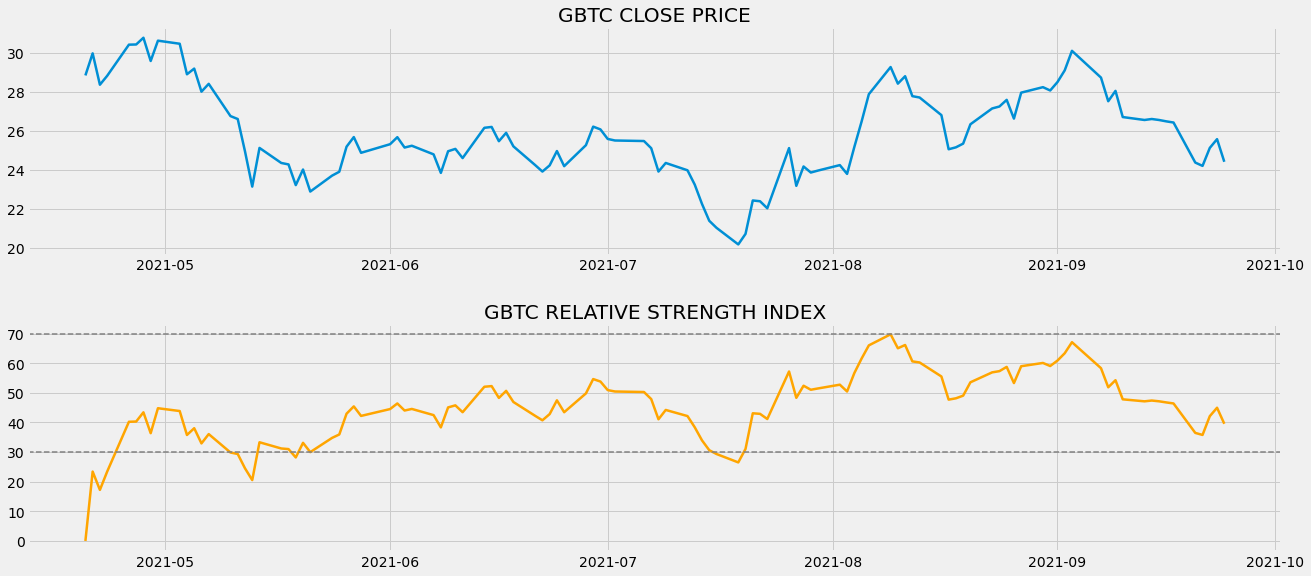

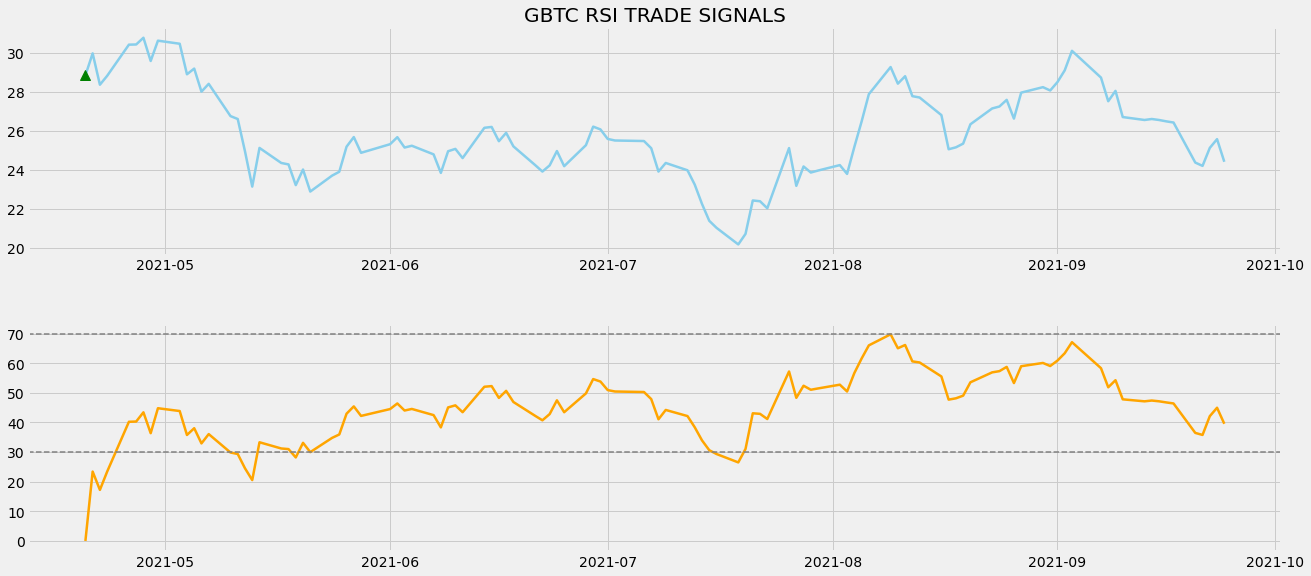

              close     rsi_14  rsi_signal  rsi_position
2021-04-20  28.8400   0.000000           1             1
2021-04-21  29.9700  23.417996           0             1
2021-04-22  28.3650  17.241878           0             1
2021-04-23  28.8200  23.408765           0             1
2021-04-26  30.4157  40.230159           0             1
Profit gained from the RSI strategy by investing $100k in GBTC : -18099.9
Profit percentage of the RSI strategy : -19%


In [21]:
# RSI
import pandas as pd 
import matplotlib.pyplot as plt
import requests
import numpy as np
from math import floor
from termcolor import colored as cl 

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

def get_historical_data(symbol, start_date = None):
    api_key = '00f83bac51mshba5c44255841b11p11d607jsnf6d25aeeaebe'
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

ibm = get_historical_data('DAPP', '2020-09-16')
print(ibm)

def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

ibm['rsi_14'] = get_rsi(ibm['close'], 14)
ibm = ibm.dropna()
print(ibm)

ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(ibm['close'], linewidth = 2.5)
ax1.set_title('GBTC CLOSE PRICE')
ax2.plot(ibm['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('GBTC RELATIVE STRENGTH INDEX')
plt.show()

def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = implement_rsi_strategy(ibm['close'], ibm['rsi_14'])

ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(ibm['close'], linewidth = 2.5, color = 'skyblue', label = 'IBM')
ax1.plot(ibm.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(ibm.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('GBTC RSI TRADE SIGNALS')
ax2.plot(ibm['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(ibm['close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = ibm['rsi_14']
close_price = ibm['close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(ibm.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(ibm.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

print(strategy.head())

ibm_ret = pd.DataFrame(np.diff(ibm['close'])).rename(columns = {0:'returns'})
rsi_strategy_ret = []

for i in range(len(ibm_ret)):
    returns = ibm_ret['returns'][i]*strategy['rsi_position'][i]
    rsi_strategy_ret.append(returns)
    
rsi_strategy_ret_df = pd.DataFrame(rsi_strategy_ret).rename(columns = {0:'rsi_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/ibm['close'][-1])
rsi_investment_ret = []

for i in range(len(rsi_strategy_ret_df['rsi_returns'])):
    returns = number_of_stocks*rsi_strategy_ret_df['rsi_returns'][i]
    rsi_investment_ret.append(returns)

rsi_investment_ret_df = pd.DataFrame(rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the RSI strategy by investing $100k in GBTC : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the RSI strategy : {}%'.format(profit_percentage), attrs = ['bold']))

In [12]:
# Bollinger Bands

import requests
import pandas as pd
import matplotlib.pyplot as plt

def load_data(sym="BTC", to_sym="USD", interval="5min", dtype=2, intraday=False, outputsize="full"):
    key = "00f83bac51mshba5c44255841b11p11d607jsnf6d25aeeaebe"
    if dtype == 1: # Download stock
        if intraday:
            url = "https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&interval={}&symbol={}&apikey={}&datatype=csv&outputsize={}".format(interval, sym, key, outputsize)
        else:
            url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&apikey={}&datatype=csv&outputsize={}".format(sym, key, outputsize)
    elif dtype == 2: # Download forex
        print("FX")
        if intraday:
            url = "https://www.alphavantage.co/query?function=FX_INTRADAY&interval={}&from_symbol={}&to_symbol={}&apikey={}&datatype=csv&outputsize={}".format(interval, sym, to_sym, key, outputsize)
        else:
            url = "https://www.alphavantage.co/query?function=FX_DAILY&from_symbol={}&to_symbol={}&apikey={}&datatype=csv&outputsize={}".format(sym, to_sym, key, outputsize)
    elif dtype == 3: # Download Crypto
        url = "https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={}&market={}&apikey={}&datatype=csv&outputsize={}".format(sym, to_sym, key, outputsize)
    print("Downloading", url)
    print("---")
    df = pd.read_csv(url)
# rename columns
    if dtype == 3:
        df.rename(columns={'timestamp': 'Date', 'open (USD)': 'Open', 'high (USD)': 'High', 'low (USD)': 'Low', 'close (USD)': 'Close', 'volume': 'Volume'}, inplace=True)
    else:
        df.rename(columns={'timestamp': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    df.sort_values(by="Date", ascending=True, inplace=True)
    print("Data loaded:", len(df), "rows")
    return df
# Options
sym = "EUR"
to_sym = "USD" # only for fx and cryptocurrency
intraday = False # False: Daily
interval = "5min" # 1min 5min 15min 30min 60min - only if intraday is set to True
dtype = 2 # 1: stock 2: fx 3: crypto
# load data
df = load_data(sym, to_sym, interval, dtype, intraday)
df['Close'].plot(figsize=(15, 10))

def add_bb(df, dev=2, lb=20, col="Close", lines=100):
    df['MA'] = df[col].rolling(lb).mean()
    df['STD'] = df[col].rolling(lb).std()
    df['OVB'] = df['MA'] + df['STD'] * dev
    df['OVS'] = df['MA'] - df['STD'] * dev
    plot_candles(df, lines=lines)
    get_stats(df, dev=dev)
    
def plot_candles(df, lines=100):
    df['Bar'] = df['High'] - df['Low']
    df['Body'] = abs(df['Close'] - df['Open'])
    df['Up'] = df['Close'] > df['Open']
    df['Color'] = np.where(df['Up'], "g", "r")
    if lines > 0:
        db = df[-lines:].reset_index(drop=True).reset_index()
    else:
        db = df.reset_index(drop=True).reset_index()
    plt.figure(figsize=(15, 10))
    plt.bar(db['index'], bottom=db['Low'], height=db['Bar'], color="#000000", width=0.2)
    plt.bar(db['index'], bottom=np.where(db['Up'], db['Open'], db['Close']), height=db['Body'], color=db['Color'], width=0.9)
    plt.plot(db['OVB'], color="b")
    plt.plot(db['OVS'], color="b")
    plt.show()
    
def get_stats(df, high_col="Close", low_col="Close", high_dev="OVB", low_dev="OVS", dev=2):
    total = len(df)
    inside = len(df[(df[high_col]<=df[high_dev]) & (df[low_col]>=df[low_dev])])
    upside = len(df[df[high_col]>=df[high_dev]])
    downside = len(df[df[low_col]<=df[low_dev]])
    i = np.round(inside / total * 100, 2)
    u = np.round(upside / total * 100, 2)
    d = np.round(downside / total * 100, 2)
    # Print the stats
    print("Total bars:", total)
    print("Deviation", dev)
    print("Inside: ", i, "%", sep="")
    print("Up side: ", u, "%", sep="")
    print("Down side: ", d, "%", sep="")
    
dev = 2 # standard deviation
lb = 20 # simple moving average (SMA) of last 20 bars including the final bar
lines = 500 # plot last 500 bars only
add_bb(df, dev=dev, lb=lb, lines=lines)

df['Close'].hist(bins=500, figsize=(15, 10))

FX
---


KeyError: 'Date'

In [2]:
import numpy as np
import pandas as pd
import talib,time,threading
from binance.helpers import *
from binance.client import Client
from binance.websockets import BinanceSocketManager
import requests,json

### ALERT ME WHENEVER MACD CROSSOVER IN DIFFERENT INTERVALS ACROSS DIFFERENT PAIRS DEFINED BELOW.

discord_webhook = "https://discord.com/api/webhooks/xxx/xxxxxxx"

client = Client('xxx','xxxx')

INTERVALS_CONFIG = {1:client.KLINE_INTERVAL_1MINUTE,3:client.KLINE_INTERVAL_3MINUTE,5:client.KLINE_INTERVAL_5MINUTE,15:client.KLINE_INTERVAL_15MINUTE}
DISTANCE_CONFIG = {1:-0.000400000,3:-0.000900000,5:-0.001300000,15:-0.009000000} ### ADJUST ACORDINGLY TO FALSE POSITIVE  OR MISSING RESULTS

CONFIG = {3:["XRPUSDT","ETHUSDT","XLMUSDT","BTCUSDT","ADAUSDT"],1:["XRPUSDT","ETHUSDT","XLMUSDT","BTCUSDT","ADAUSDT"],1:["XRPUSDT","ETHUSDT","XLMUSDT","BTCUSDT","ADAUSDT"],5:["ETHUSDT"],15:["ETHUSDT","ADAUSDT","BNBUSDT"]}

previous_notified_at = {}

FALSE_POSITIVE_LAST_ELEMENTS_CHECK = -4 ## ex: last 4 candles of 1 min  chart,5 min , 3 min charts  

### check if all the elements in list are same.
def ckeckList(lst): 
    ele = lst[0] 
    chk = True
    for item in lst: 
        if ele != item: 
            chk = False
            break; 
              
    if (chk == True): return True
    else: return False     

class MACD_Monitor:
    def __init__(self):
        self.threads = []

        for interval,tokens in CONFIG.items():
            for each_token in tokens:
                previous_notified_at["{}:{}".format(each_token,interval)] = datetime.fromtimestamp(1545730073)

        while True:
            for interval,tokens in CONFIG.items():
                for each_token in tokens:
                    self.process(each_token,interval)

    def process(self,token,interval):
        data_df = self.get_historical_candles(token,interval)
        closes = []

        current_time = datetime.fromtimestamp(time.time())

        all_calc_values = []
        for each_close,close_time in zip(data_df['close'],data_df['datetime']):
            try:
                closes.append(each_close)
                np_closes = np.array(closes)

                MACD, signal, macdhist = talib.MACD(np_closes, fastperiod=12, slowperiod=26, signalperiod=9)

                last_macd = MACD[-1]
                last_signal = signal[-1]

                
                rsi_val = talib.RSI(np_closes)
                
                last_rsi = rsi_val[-1]


                calc = str(round(last_macd - last_signal,8))

                val = "{}:{}".format(each_close,float(calc))
                all_calc_values.append(val)

                if '-' in calc:
                    state = "DOWN"
                    if float(calc) >= DISTANCE_CONFIG[interval] * each_close:  
                        if str(float(calc)).startswith('-'):
                            
                            ##  False positive , like when green line just get crossover from above to red below and make closed distance from below.
                            re_check = ["-" in each_val.split(":")[1] for each_val in all_calc_values[FALSE_POSITIVE_LAST_ELEMENTS_CHECK:]]
                        
                            if ckeckList(re_check): ## if  all previous elements are True, which means they are making close contant from below to red

                                time_diff = current_time - close_time
                                
                                total_seconds_to_minutes = time_diff.total_seconds() / 60
                                if total_seconds_to_minutes <= interval: ## minute based, if it is making close within 5 or 1 or whatever interval of now seconds
                                    
                                    ## notify only latest
                                    if self.check_last_alert(interval,token):
                                        print(token," | ",interval," | ",close_time," | ",float(calc)," | ",last_rsi)## else line crossed just now
                                        #print(last_fastk,last_fastd)
                                        #print(re_check) ## check if all previous occurences are negative

                                        previous_notified_at["{}:{}".format(token,interval)] = datetime.fromtimestamp(time.time())

                                        t = threading.Thread(target=self.discord_push,args=(token,interval,close_time,float(calc),last_rsi))
                                        t.start()

                        else:
                            val = "{}:{}".format(each_close,float(calc))
                            all_calc_values.append(val)
                                
                else:
                    state = "UP"
                    val = "{}:{}".format(each_close,float(calc))
                    all_calc_values.append(val)

            except Exception as e:
                print("[EXCEPTION] : ",e)

    def check_last_alert(self,interval,token):
        get_stored_time = previous_notified_at["{}:{}".format(token,interval)]
        current_time = datetime.fromtimestamp(time.time())
        calc = current_time - get_stored_time

        if interval == 1:
            interval = interval * 4
        if interval == 3: ### extra time for  1 minute chart and 3 minute chart
            interval = interval * 3
        if interval == 5:
            interval = interval * 2

        if calc.seconds / 60 > interval:
            return True
        else:
            return False


    def discord_push(self,token,interval,close_time,calc,last_rsi):
        try:
            message = "`[{}]` : https://www.binance.com/en/trade/{}?layout=pro : `[{}]`".format(close_time,token.replace("USDT","_USDT"),calc)
        
            data = {}
            data['content'] = message
            data['embeds'] = []
            embed = {}
            embed['description'] = "RSI : {}  ,  {} minutes".format(round(last_rsi,2),interval)
            embed['title'] = token.replace("USDT","")
            data["embeds"].append(embed)

            results = requests.post(discord_webhook,data=json.dumps(data),headers={"Content-Type": "application/json"})
            
            self.write_to_file(token,interval,close_time,calc)
        except Exception as e:
            print("[*] EXCEPTION IN NOTIFY PUSH : {}".format(e))
            return True

    def write_to_file(self,token,interval,time,calc):
        with open('crypto_macd_log.txt','a+') as f:
            f.write("{} : {} : {} : {}\n".format(token,interval,time,calc))
        f.close()

    def get_historical_candles(self,symbol,interval):
        record = client.get_historical_klines(symbol,INTERVALS_CONFIG[interval], "10 hour ago UTC")
        myList = []

        try:
            for item in record:
                n_item = []
                int_ts = int(item[0] / 1000)
                # nur neue timestamps anhängen

                n_item.append(int_ts)  # open time
                n_item.append(float(item[1]))  # open
                n_item.append(float(item[2]))  # high
                n_item.append(float(item[3]))  # low
                n_item.append(float(item[4]))  # close
                n_item.append(float(item[5]))  # volume
                n_item.append(int(item[6] / 1000))  # close_time
                n_item.append(float(item[7]))  # quote_assetv
                n_item.append(int(item[8]))  # trades
                n_item.append(float(item[9]))  # taker_b_asset_v
                n_item.append(float(item[10]))  # taker_b_quote_v
                n_item.append(datetime.fromtimestamp(n_item[0]))
                myList.append(n_item)
        except Exception as error:
            debug_logger.debug(error)

        new_ohlc = pd.DataFrame(myList, columns=['open_time', 'open', 'high', 'low',
                                                    'close', 'volume', 'close_time', 'quote_assetv', 'trades',
                                                    'taker_b_asset_v',
                                                    'taker_b_quote_v', 'datetime'])

        return new_ohlc


m = MACD_Monitor()

ModuleNotFoundError: No module named 'binance.websockets'

In [3]:
import pandas as pd

from_symbol = 'ETH'
to_symbol = 'USD'
exchange = 'Bitstamp'
datetime_interval = 'day'

import requests
from datetime import datetime


def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s_%s_%s_%s_%s.csv' % (from_symbol, to_symbol, exchange, datetime_interval, download_date)


def download_data(from_symbol, to_symbol, exchange, datetime_interval):
    supported_intervals = {'minute', 'hour', 'day'}
    assert datetime_interval in supported_intervals,\
        'datetime_interval should be one of %s' % supported_intervals

    print('Downloading %s trading data for %s %s from %s' %
          (datetime_interval, from_symbol, to_symbol, exchange))
    base_url = 'https://min-api.cryptocompare.com/data/histo'
    url = '%s%s' % (base_url, datetime_interval)

    params = {'fsym': from_symbol, 'tsym': to_symbol,
              'limit': 2000, 'aggregate': 1,
              'e': exchange}
    request = requests.get(url, params=params)
    data = request.json()
    return data


def convert_to_dataframe(data):
    df = pd.json_normalize(data, ['Data'])
    df['datetime'] = pd.to_datetime(df.time, unit='s')
    df = df[['datetime', 'low', 'high', 'open',
             'close', 'volumefrom', 'volumeto']]
    return df


def filter_empty_datapoints(df):
    indices = df[df.sum(axis=1) == 0].index
    print('Filtering %d empty datapoints' % indices.shape[0])
    df = df.drop(indices)
    return df


data = download_data(from_symbol, to_symbol, exchange, datetime_interval)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)

current_datetime = datetime.now().date().isoformat()
filename = get_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime)
print('Saving data to %s' % filename)
df.to_csv(filename, index=False)

Filtering 581 empty datapoints
Saving data to ETH_USD_Bitstamp_day_2021-09-28.csv


In [4]:
import pandas as pd

def read_dataset(filename):
    print('Reading data from %s' % filename)
    df = pd.read_csv(filename)
    df.datetime = pd.to_datetime(df.datetime) # change type from object to datetime
    df = df.set_index('datetime') 
    df = df.sort_index() # sort by datetime
    print(df.shape)
    return df

df = read_dataset(filename)

Reading data from ETH_USD_Bitstamp_day_2021-09-28.csv
(1420, 6)


In [5]:
from stockstats import StockDataFrame
df = StockDataFrame.retype(df)
df['macd'] = df.get('macd') # calculate MACD

In [6]:
from math import pi

from bokeh.plotting import figure, show, output_notebook, output_file
output_notebook()

datetime_from = '2021-01-01 00:00'
datetime_to = '2021-12-10 00:00'


def get_candlestick_width(datetime_interval):
    if datetime_interval == 'minute':
        return 30 * 60 * 1000  # half minute in ms
    elif datetime_interval == 'hour':
        return 0.5 * 60 * 60 * 1000  # half hour in ms
    elif datetime_interval == 'day':
        return 12 * 60 * 60 * 1000  # half day in ms


df_limit = df[datetime_from: datetime_to].copy()
inc = df_limit.close > df_limit.open
dec = df_limit.open > df_limit.close

title = '%s datapoints from %s to %s for %s and %s from %s with MACD strategy' % (
    datetime_interval, datetime_from, datetime_to, from_symbol, to_symbol, exchange)
p = figure(x_axis_type="datetime",  plot_width=1000, title=title)

p.line(df_limit.index, df_limit.close, color='black')

# plot macd strategy
p.line(df_limit.index, 0, color='black')
p.line(df_limit.index, df_limit.macd, color='blue')
p.line(df_limit.index, df_limit.macds, color='orange')
p.vbar(x=df_limit.index, bottom=[
       0 for _ in df_limit.index], top=df_limit.macdh, width=4, color="purple")

# plot candlesticks
candlestick_width = get_candlestick_width(datetime_interval)
p.segment(df_limit.index, df_limit.high,
          df_limit.index, df_limit.low, color="black")
p.vbar(df_limit.index[inc], candlestick_width, df_limit.open[inc],
       df_limit.close[inc], fill_color="#D5E1DD", line_color="black")
p.vbar(df_limit.index[dec], candlestick_width, df_limit.open[dec],
       df_limit.close[dec], fill_color="#F2583E", line_color="black")

output_file("visualizing_trading_strategy.html", title="visualizing trading strategy")
show(p)

Loading BokehJS ...